<a href="https://colab.research.google.com/github/ergul13/mr_akgul/blob/main/%C3%A7oklu_s%C4%B1n%C4%B1fland%C4%B1rma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import os
from google.colab import drive

# 1. Drive Bağlantısı
drive.mount('/content/drive', force_remount=True)

# 2. Ana Dizin ve CSV Yolları
base_dir = '/content/drive/MyDrive/Meme_Kanseri_Proje_Verileri'
train_csv = os.path.join(base_dir, 'SPLIT_DATA', 'train.csv')
val_csv = os.path.join(base_dir, 'SPLIT_DATA', 'val.csv')
test_csv = os.path.join(base_dir, 'SPLIT_DATA', 'test.csv')

# 3. Verileri Yükleme ve Yol Düzeltme Fonksiyonu
def load_and_fix_paths(csv_path):
    if not os.path.exists(csv_path):
        return pd.DataFrame()

    df = pd.read_csv(csv_path)
    if 'path' in df.columns:
        # Eski yolları yeni klasör yapısına yönlendir
        df['path'] = df['path'].str.replace(
            '/content/drive/MyDrive/',
            '/content/drive/MyDrive/Meme_Kanseri_Proje_Verileri/',
            regex=False
        )
    return df

df_train = load_and_fix_paths(train_csv)
df_val = load_and_fix_paths(val_csv)
df_test = load_and_fix_paths(test_csv)

print(f"Veri Setleri Yüklendi:")
print(f"Eğitim: {len(df_train)} satır")
print(f"Doğrulama: {len(df_val)} satır")
print(f"Test: {len(df_test)} satır")
print(f"Toplam görüntü sayısı: {len(df_train) + len(df_val)+ len(df_test)}")

Mounted at /content/drive
Veri Setleri Yüklendi:
Eğitim: 44092 satır
Doğrulama: 5512 satır
Test: 5512 satır
Toplam görüntü sayısı: 55116


In [2]:
# Sınıf Dağılım Tablosu Oluşturma
def create_distribution_table(df_train, df_val, df_test):
    # Tüm setlerdeki benzersiz sınıfları bul
    all_classes = sorted(df_train['label'].unique())

    stats = []
    for cls in all_classes:
        train_c = len(df_train[df_train['label'] == cls])
        val_c = len(df_val[df_val['label'] == cls]) if not df_val.empty else 0
        test_c = len(df_test[df_test['label'] == cls])
        total = train_c + val_c + test_c

        # Eğitim seti içindeki oranı
        ratio = (train_c / len(df_train) * 100) if len(df_train) > 0 else 0

        stats.append({
            'BI-RADS Sınıfı': cls,
            'Eğitim (Adet)': train_c,
            'Doğrulama (Adet)': val_c,
            'Test (Adet)': test_c,
            'Toplam': total,
            'Eğitim Payı (%)': f"%{ratio:.2f}"
        })

    return pd.DataFrame(stats)

stat_table = create_distribution_table(df_train, df_val, df_test)

print("VERİ SETİ SINIF DAĞILIM İSTATİSTİKLERİ")
print("-" * 80)
print(stat_table.to_string(index=False))
print("-" * 80)
print(f"\nToplam Görüntü Sayısı: {stat_table['Toplam'].sum()}")

VERİ SETİ SINIF DAĞILIM İSTATİSTİKLERİ
--------------------------------------------------------------------------------
 BI-RADS Sınıfı  Eğitim (Adet)  Doğrulama (Adet)  Test (Adet)  Toplam Eğitim Payı (%)
              1          42891              5362         5362   53615          %97.28
              2            194                24           25     243           %0.44
              4             35                 4            4      43           %0.08
              5            972               122          121    1215           %2.20
--------------------------------------------------------------------------------

Toplam Görüntü Sayısı: 55116


In [4]:
import pandas as pd
import os
import shutil
from sklearn.utils import resample
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 1. TEMEL AYARLAR VE VERİ YÜKLEME
base_dir = '/content/drive/MyDrive/Meme_Kanseri_Proje_Verileri'
train_csv = os.path.join(base_dir, 'SPLIT_DATA', 'train.csv')
val_csv = os.path.join(base_dir, 'SPLIT_DATA', 'val.csv')

# Yükleme Fonksiyonu
def load_and_fix(path):
    if os.path.exists(path):
        df = pd.read_csv(path)
        if 'path' in df.columns:
            # Yolları güncelle
            df['path'] = df['path'].str.replace(
                '/content/drive/MyDrive/',
                '/content/drive/MyDrive/Meme_Kanseri_Proje_Verileri/',
                regex=False
            )
        return df
    return pd.DataFrame()

df_train = load_and_fix(train_csv)
df_val = load_and_fix(val_csv)

# 2. MODEL 3 (BI-RADS 4) VERİ SETİNİ HAZIRLAMA (EKSİK OLAN KISIM)
def prepare_model3_data(df, target_class=4):
    # Pozitif Sınıf (4)
    df_pos = df[df['label'] == target_class].copy()

    # Augmentation İşaretlemesi (4 Kat)
    aug_data = []
    for _, row in df_pos.iterrows():
        aug_data.append({'path': row['path'], 'binary_label': 1, 'aug_type': 'original'})
        aug_data.append({'path': row['path'], 'binary_label': 1, 'aug_type': 'rot90'})
        aug_data.append({'path': row['path'], 'binary_label': 1, 'aug_type': 'rot180'})
        aug_data.append({'path': row['path'], 'binary_label': 1, 'aug_type': 'rot270'})
    df_pos_aug = pd.DataFrame(aug_data)

    # Negatif Sınıf (Diğerleri)
    df_neg = df[df['label'] != target_class].copy()
    n_pos = len(df_pos_aug)
    n_neg = min(len(df_neg), n_pos * 2) # 1:2 Oran

    if n_neg > 0:
        df_neg_sampled = resample(df_neg, n_samples=n_neg, replace=False, random_state=42)
        neg_data = [{'path': row['path'], 'binary_label': 0, 'aug_type': 'original'} for _, row in df_neg_sampled.iterrows()]
        return pd.concat([df_pos_aug, pd.DataFrame(neg_data)]).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_pos_aug

# Değişkenleri Oluştur
df_train_m3 = prepare_model3_data(df_train)

# Validation Hazırlığı
val_list = []
if not df_val.empty:
    for _, row in df_val.iterrows():
        label = 1 if row['label'] == 4 else 0
        val_list.append({'path': row['path'], 'binary_label': label, 'aug_type': 'original'})
    df_val_m3 = pd.DataFrame(val_list)
else:
    df_val_m3 = pd.DataFrame()

print(f"Model 3 Eğitim Verisi: {len(df_train_m3)} adet")
print(f"Model 3 Doğrulama Verisi: {len(df_val_m3)} adet")

# 3. PARALEL KOPYALAMA (HIZLANDIRILMIŞ)
local_dir = '/content/local_data'
if os.path.exists(local_dir): shutil.rmtree(local_dir)
os.makedirs(local_dir, exist_ok=True)

# Kopyalanacak benzersiz dosyalar
files_to_copy = list(set(df_train_m3['path'].tolist() + df_val_m3['path'].tolist()))
path_map = {}

print(f"\n{len(files_to_copy)} dosya paralel olarak kopyalanıyor...")

def copy_worker(src):
    try:
        if os.path.exists(src):
            dst = os.path.join(local_dir, os.path.basename(src))
            shutil.copy(src, dst)
            return src, dst
    except:
        return None, None
    return None, None

# 16 Thread ile kopyala
with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(tqdm(executor.map(copy_worker, files_to_copy), total=len(files_to_copy)))

# Haritalamayı güncelle
for src, dst in results:
    if src and dst:
        path_map[src] = dst

# DataFrame yollarını yerel diske çevir
df_train_m3['path'] = df_train_m3['path'].map(path_map).dropna()
df_val_m3['path'] = df_val_m3['path'].map(path_map).dropna()

print("\nVeri hazırlığı ve taşıma tamamlandı. Eğitim kodunu çalıştırabilirsin.")

Model 3 Eğitim Verisi: 420 adet
Model 3 Doğrulama Verisi: 5512 adet

5827 dosya paralel olarak kopyalanıyor...


100%|██████████| 5827/5827 [04:55<00:00, 19.69it/s]


Veri hazırlığı ve taşıma tamamlandı. Eğitim kodunu çalıştırabilirsin.


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import cv2
import numpy as np

# Dataset Sınıfı
class MammographyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img = cv2.imread(row['path'])

        if img is None:
            img = np.zeros((224, 224), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224, 224))

        # Augmentation Uygulama
        aug = row['aug_type']
        if aug == 'rot90': img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif aug == 'rot180': img = cv2.rotate(img, cv2.ROTATE_180)
        elif aug == 'rot270': img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Normalize ve Tensor
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0) # (1, 224, 224)

        return torch.from_numpy(img), torch.tensor(row['binary_label'], dtype=torch.float32)

# Swish Aktivasyonu
class Swish(nn.Module):
    def forward(self, x): return x * torch.sigmoid(x)

# Model Mimarisi
class MammographyModel(nn.Module):
    def __init__(self):
        super(MammographyModel, self).__init__()
        # ResNet18 Backbone
        self.base = models.resnet18(weights='DEFAULT')
        # İlk katman 1 kanal (Grayscale) için
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Identity()

        # Sınıflandırıcı
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        features = self.base(x)
        return self.classifier(features)

In [7]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Ayarlar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 10

print(f"Eğitim Cihazı: {device}")

# DataLoader
train_loader = DataLoader(MammographyDataset(df_train_m3), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(MammographyDataset(df_val_m3), batch_size=BATCH_SIZE, shuffle=False)

# Model Başlatma
model = MammographyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Eğitim Döngüsü
best_f1 = 0.0

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    val_f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_bi-rads4.pth')
        print("-> Model Kaydedildi.")

Eğitim Cihazı: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


Epoch 1/10 | Loss: 0.4631 | Val F1: 0.0000
Epoch 2/10 | Loss: 0.2467 | Val F1: 0.0057
-> Model Kaydedildi.
Epoch 3/10 | Loss: 0.1739 | Val F1: 0.0072
-> Model Kaydedildi.
Epoch 4/10 | Loss: 0.0980 | Val F1: 0.0112
-> Model Kaydedildi.
Epoch 5/10 | Loss: 0.0475 | Val F1: 0.0247
-> Model Kaydedildi.
Epoch 6/10 | Loss: 0.0401 | Val F1: 0.0397
-> Model Kaydedildi.
Epoch 7/10 | Loss: 0.0505 | Val F1: 0.0206
Epoch 8/10 | Loss: 0.0749 | Val F1: 0.0128
Epoch 9/10 | Loss: 0.1341 | Val F1: 0.0105
Epoch 10/10 | Loss: 0.0685 | Val F1: 0.0800
-> Model Kaydedildi.


##sonuçlar çok kötü ama zaten ne bekliyoruz

Pozitif Sınıf Ağırlığı (Ceza Katsayısı): 2.00
Bu şu demek: Model 1 kanserli hücreyi kaçırırsa, normal hatanın 2.00 katı ceza alacak.

--- Ağırlıklı Eğitim Başlıyor ---
Epoch 1/15 | Loss: 0.8743 | Val F1: 0.0000 | Recall: 0.0000
Epoch 2/15 | Loss: 0.7412 | Val F1: 0.0000 | Recall: 0.0000
Epoch 3/15 | Loss: 0.6444 | Val F1: 0.0027 | Recall: 0.5000
Epoch 4/15 | Loss: 0.5690 | Val F1: 0.0048 | Recall: 1.0000
Epoch 5/15 | Loss: 0.5195 | Val F1: 0.0048 | Recall: 1.0000
Epoch 6/15 | Loss: 0.4668 | Val F1: 0.0050 | Recall: 1.0000
Epoch 7/15 | Loss: 0.4234 | Val F1: 0.0053 | Recall: 1.0000
Epoch 8/15 | Loss: 0.3807 | Val F1: 0.0064 | Recall: 1.0000
Epoch 9/15 | Loss: 0.3558 | Val F1: 0.0072 | Recall: 1.0000
Epoch 10/15 | Loss: 0.3221 | Val F1: 0.0087 | Recall: 1.0000
Epoch 11/15 | Loss: 0.3000 | Val F1: 0.0097 | Recall: 0.7500
Epoch 12/15 | Loss: 0.2587 | Val F1: 0.0122 | Recall: 0.7500
Epoch 13/15 | Loss: 0.2326 | Val F1: 0.0176 | Recall: 0.7500
Epoch 14/15 | Loss: 0.2050 | Val F1: 0.0144 | Re

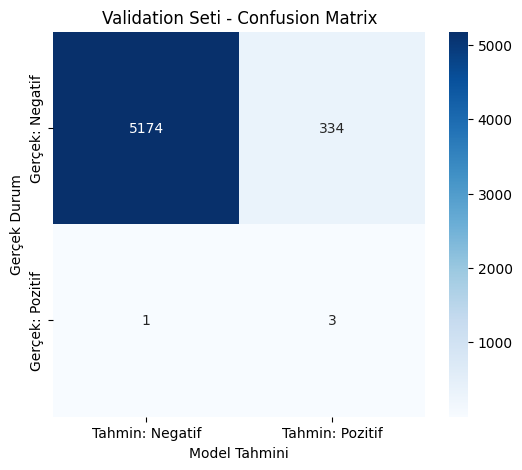

Final Recall Skoru: 0.7500


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. AĞIRLIK HESAPLAMA (KRİTİK ADIM) ---
# Pozitif örnekler az olduğu için onları daha değerli kılıyoruz.
# Formül: Negatif Sayısı / Pozitif Sayısı
# Model 3 Veri setindeki (df_train_m3) oranlara bakıyoruz.
num_pos = len(df_train_m3[df_train_m3['binary_label'] == 1])
num_neg = len(df_train_m3[df_train_m3['binary_label'] == 0])

# Eğer pozitif 0 ise hata vermesin diye kontrol
if num_pos > 0:
    pos_weight_value = num_neg / num_pos
else:
    pos_weight_value = 1.0

# H100 veya T4 GPU'ya taşıma
pos_weight_tensor = torch.tensor([pos_weight_value]).to(device)

print(f"Pozitif Sınıf Ağırlığı (Ceza Katsayısı): {pos_weight_value:.2f}")
print("Bu şu demek: Model 1 kanserli hücreyi kaçırırsa, normal hatanın {:.2f} katı ceza alacak.".format(pos_weight_value))

# --- 2. MODEL VE LOSS TANIMI ---
# Modeli tekrar sıfırdan başlatıyoruz
model = MammographyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5) # Learning rate'i biraz düşürdük (daha hassas öğrensin)

# BCEWithLogitsLoss içine pos_weight parametresini ekliyoruz
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# --- 3. GELİŞMİŞ EĞİTİM DÖNGÜSÜ ---
EPOCHS = 15 # Epoch sayısını artırdık
best_f1 = 0.0
history = {'train_loss': [], 'val_f1': [], 'val_recall': []}

print("\n--- Ağırlıklı Eğitim Başlıyor ---")

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Ağırlıklı Loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Metrikler
    val_f1 = f1_score(all_labels, all_preds, zero_division=0)
    val_recall = recall_score(all_labels, all_preds, zero_division=0) # Recall: Kanserlilerin kaçını yakaladık?

    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_f1)
    history['val_recall'].append(val_recall)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Recall: {val_recall:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_3_weighted.pth')

# --- 4. CONFUSION MATRIX (KARMAŞIKLIK MATRİSİ) ---
# Modelin hatalarını görselleştirelim
print("\nEn iyi modelin performans analizi:")
model.load_state_dict(torch.load('best_model_3_weighted.pth'))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        preds = torch.sigmoid(model(inputs)) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tahmin: Negatif', 'Tahmin: Pozitif'], yticklabels=['Gerçek: Negatif', 'Gerçek: Pozitif'])
plt.title('Validation Seti - Confusion Matrix')
plt.ylabel('Gerçek Durum')
plt.xlabel('Model Tahmini')
plt.show()

# Recall'un önemi: Recall yüksekse kanserleri kaçırmıyoruz demektir (Yanlış alarm olsa bile).
print(f"Final Recall Skoru: {recall_score(all_labels, all_preds):.4f}")

**ee o zaman herkese kanser diyelim kardeşim bu nasıl iş**